# PCA style autoencoder

Attempt at implementing some of the PCA style principles in the setup and training of the autoencoder

Somewhat inspired by what's here (https://towardsdatascience.com/build-the-right-autoencoder-tune-and-optimize-using-pca-principles-part-ii-24b9cca69bd6), though not doing all of these things yet

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import LogNorm

import h5py

In [2]:
import tensorflow as tf

from tensorflow.keras.layers import Input, Flatten, MaxPooling2D, Dense, Conv2D, Conv2DTranspose, Reshape, UpSampling2D, Layer, InputSpec
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import regularizers, activations, initializers, constraints, Sequential
from tensorflow.keras.constraints import UnitNorm, Constraint
from tensorflow.keras.callbacks import EarlyStopping

#### Load data

Load data from ptychography simulation datasets from Panpan.

Crop the images to the central 32x32

In [3]:
#change path to your location
pathToSimData="/Users/dnoonan/Work/AIinPixel/simulated ptychography dataset"

with h5py.File(f"{pathToSimData}/data_cell_phase_n2e7.h5", "r") as f:
    dataFull = f['exchange/data'][...][0].real**2
with h5py.File(f"{pathToSimData}/data_cell_phase_n2e7_ref.h5", "r") as f:
    dataFull_ref = f['exchange/data'][...][0].real**2
    
data = dataFull[:,36-16:36+16,36-16:36+16]
data_ref = dataFull_ref[:,36-16:36+16,36-16:36+16]

Flatten the data, and also make a version of the data that is log scale

In [4]:
dataFlat = data.reshape(-1,32*32)
dataFlatLog = np.where(dataFlat>0,np.log2(dataFlat*2),0)

dataRefFlat = data_ref.reshape(-1,32*32)
dataRefFlatLog = np.where(dataRefFlat>0,np.log2(dataRefFlat*2),0)


/var/folders/j1/jkcgqtn54x77dthw487gytn80000gp/T/ipykernel_15699/2804436543.py:2: RuntimeWarning: divide by zero encountered in log2
  dataFlatLog = np.where(dataFlat>0,np.log2(dataFlat*2),0)
/var/folders/j1/jkcgqtn54x77dthw487gytn80000gp/T/ipykernel_15699/2804436543.py:5: RuntimeWarning: divide by zero encountered in log2
  dataRefFlatLog = np.where(dataRefFlat>0,np.log2(dataRefFlat*2),0)


### Single Dense Layer network, emulating PCA

PCA and a dense layer are essentially the same calculation, just matrix multiplication.  Try training just a dense network, cutting down to 128 encoded values (factor of 8 compression).

In [5]:
inputs = Input(shape=(1024),name='input')
encoder = Dense(128, activation="linear")
decoder = Dense(1024, activation="linear")

x = encoder(inputs)
x = decoder(x)

autoencoder = Model(inputs, x)
autoencoder.summary()
autoencoder.compile(metrics=['accuracy'],optimizer="adam", loss="mse")

autoencoder.fit(dataFlatLog, dataFlatLog,
                epochs=100,
                validation_split=.1,
               )

2021-07-28 16:11:34.455625: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              132096    
Total params: 263,296
Trainable params: 263,296
Non-trainable params: 0
_________________________________________________________________


2021-07-28 16:11:35.702557: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
127/127 [==============================] - 1s 7ms/step - loss: 0.3924 - accuracy: 0.6400 - val_loss: 0.0634 - val_accuracy: 0.9800
Epoch 2/100
127/127 [==============================] - 1s 5ms/step - loss: 0.1111 - accuracy: 0.8326 - val_loss: 0.0541 - val_accuracy: 0.9866
Epoch 3/100
127/127 [==============================] - 0s 4ms/step - loss: 0.0882 - accuracy: 0.8814 - val_loss: 0.0484 - val_accuracy: 0.9889
Epoch 4/100
127/127 [==============================] - 1s 7ms/step - loss: 0.0773 - accuracy: 0.8968 - val_loss: 0.0449 - val_accuracy: 0.9978
Epoch 5/100
127/127 [==============================] - 1s 6ms/step - loss: 0.0706 - accuracy: 0.9012 - val_loss: 0.0407 - val_accuracy: 0.9733
Epoch 6/100
127/127 [==============================] - 1s 5ms/step - loss: 0.0652 - accuracy: 0.8995 - val_loss: 0.0371 - val_accuracy: 0.9688
Epoch 7/100
127/127 [==============================] - 1s 5ms/step - loss: 0.0604 - accuracy: 0.8975 - val_loss: 0.0334 - val_accuracy: 0.9555

Epoch 58/100
127/127 [==============================] - 1s 6ms/step - loss: 0.0238 - accuracy: 0.9552 - val_loss: 0.0069 - val_accuracy: 1.0000
Epoch 59/100
127/127 [==============================] - 1s 5ms/step - loss: 0.0240 - accuracy: 0.9574 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 60/100
127/127 [==============================] - 1s 5ms/step - loss: 0.0238 - accuracy: 0.9574 - val_loss: 0.0073 - val_accuracy: 1.0000
Epoch 61/100
127/127 [==============================] - 1s 5ms/step - loss: 0.0238 - accuracy: 0.9564 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 62/100
127/127 [==============================] - 1s 4ms/step - loss: 0.0239 - accuracy: 0.9562 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 63/100
127/127 [==============================] - 0s 4ms/step - loss: 0.0239 - accuracy: 0.9572 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 64/100
127/127 [==============================] - 1s 4ms/step - loss: 0.0234 - accuracy: 0.9562 - val_loss: 0.0051 - val_accuracy:

Evaluate on reference dataset

In [6]:
output = autoencoder.predict(dataRefFlatLog)
outputZS = np.where(output>0.5,output,0)

In [7]:
#pick 4 random images to plot
N_random = np.random.choice(np.arange(output.shape[0]),4)

#plot the 4 images with the higher occupied pixels
N_highest_Idx = np.argsort((dataRefFlatLog>0).sum(axis=(1)))[-16:-12]

N = np.append(N_random,N_highest_Idx)

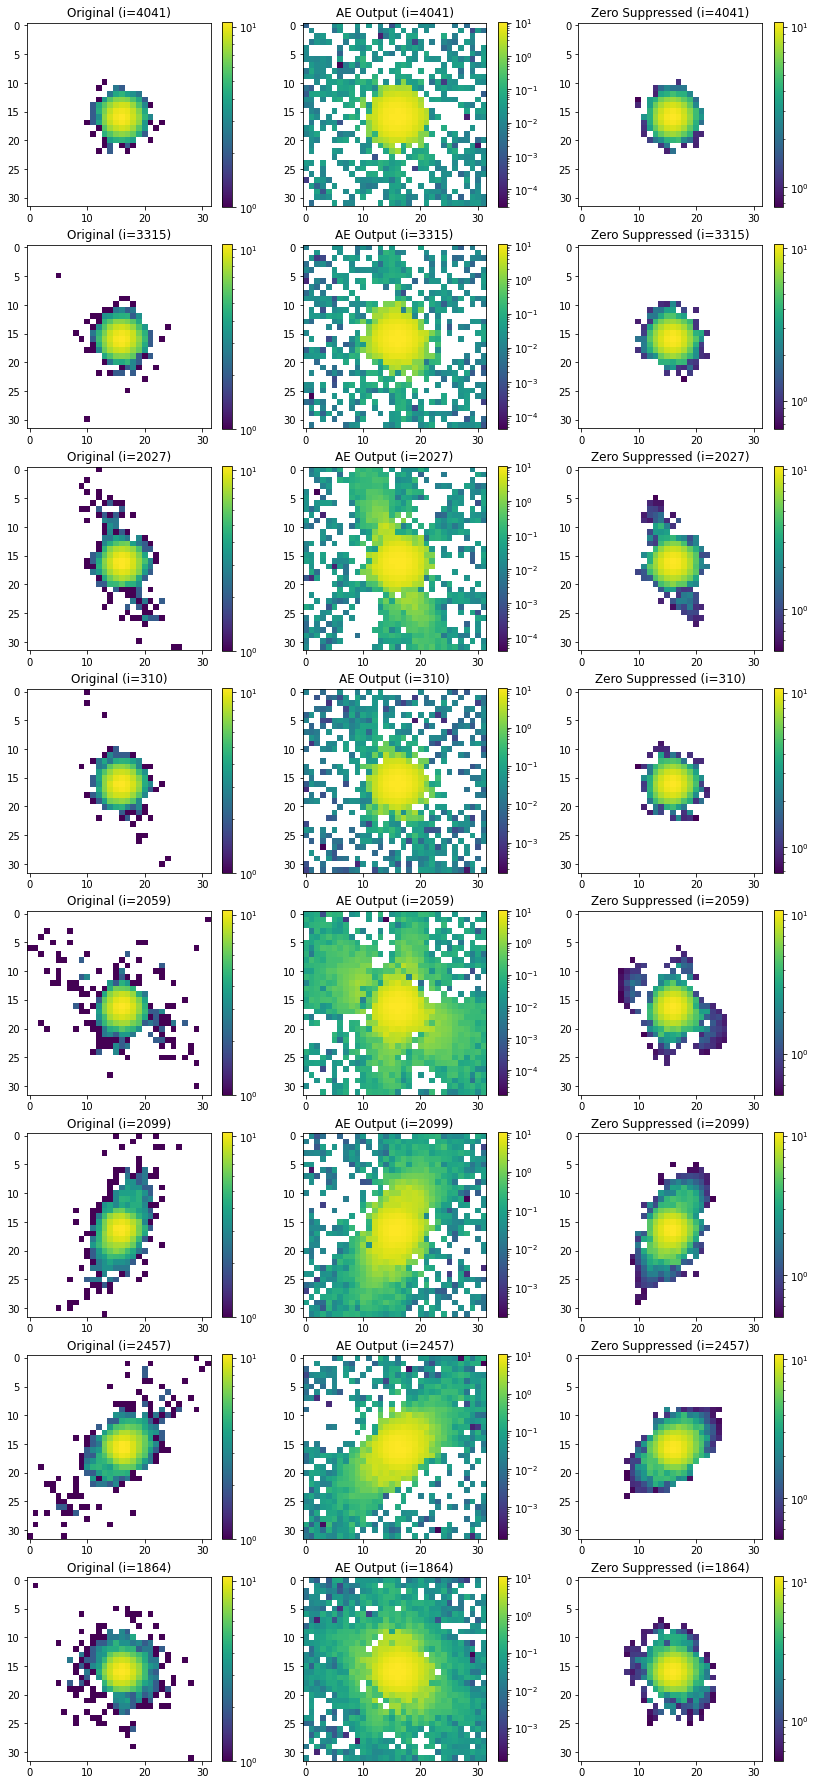

In [8]:
fig,ax = plt.subplots(len(N),3,figsize=(14,4*len(N)))

for i in range(len(N)):
    im = ax[i][0].imshow(dataFlatLog[N[i]].reshape(32,32),norm=LogNorm())
    fig.colorbar(im,ax=ax[i][0])
    ax[i][0].set_title(f'Original (i={N[i]})')
    
    im = ax[i][1].imshow(output[N[i]].reshape(32,32),norm=LogNorm())
    fig.colorbar(im,ax=ax[i][1])
    ax[i][1].set_title(f'AE Output (i={N[i]})')

    im = ax[i][2].imshow(outputZS[N[i]].reshape(32,32),norm=LogNorm())
    fig.colorbar(im,ax=ax[i][2])
    ax[i][2].set_title(f'Zero Suppressed (i={N[i]})')

    

### Single Dense Layer network, fewer encoded nodes

Try the same thing, but with more compression (64, 32, or 16 output nodes)

In [9]:
inputs = Input(shape=(1024),name='input')
encoder = Dense(64, activation="linear")
decoder = Dense(1024, activation="linear")

x = encoder(inputs)
x = decoder(x)

autoencoder64 = Model(inputs, x)
autoencoder64.summary()
autoencoder64.compile(metrics=['accuracy'],optimizer="adam", loss="mse")

history64 = autoencoder64.fit(dataFlatLog, dataFlatLog,
                  epochs=100,
                  validation_split=.1,
                  verbose=0
                 )

output64 = autoencoder64.predict(dataRefFlatLog)
output64ZS = np.where(output64>0.5,output64,0)




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1024)]            0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                65600     
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              66560     
Total params: 132,160
Trainable params: 132,160
Non-trainable params: 0
_________________________________________________________________


In [10]:
inputs = Input(shape=(1024),name='input')
encoder = Dense(32, activation="linear")
decoder = Dense(1024, activation="linear")

x = encoder(inputs)
x = decoder(x)

autoencoder32 = Model(inputs, x)
autoencoder32.summary()
autoencoder32.compile(metrics=['accuracy'],optimizer="adam", loss="mse")

history32 = autoencoder32.fit(dataFlatLog, dataFlatLog,
                  epochs=100,
                  validation_split=.1,
                  verbose=0
                 )

output32 = autoencoder32.predict(dataRefFlatLog)
output32ZS = np.where(output32>0.5,output32,0)




Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1024)]            0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                32800     
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              33792     
Total params: 66,592
Trainable params: 66,592
Non-trainable params: 0
_________________________________________________________________


In [11]:
inputs = Input(shape=(1024),name='input')
encoder = Dense(16, activation="linear")
decoder = Dense(1024, activation="linear")

x = encoder(inputs)
x = decoder(x)

autoencoder16 = Model(inputs, x)
autoencoder16.summary()
autoencoder16.compile(metrics=['accuracy'],optimizer="adam", loss="mse")

history16 = autoencoder16.fit(dataFlatLog, dataFlatLog,
                  epochs=100,
                  validation_split=.1,
                  verbose=0
                 )

output16 = autoencoder16.predict(dataRefFlatLog)
output16ZS = np.where(output16>0.5,output16,0)




Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1024)]            0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                16400     
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              17408     
Total params: 33,808
Trainable params: 33,808
Non-trainable params: 0
_________________________________________________________________


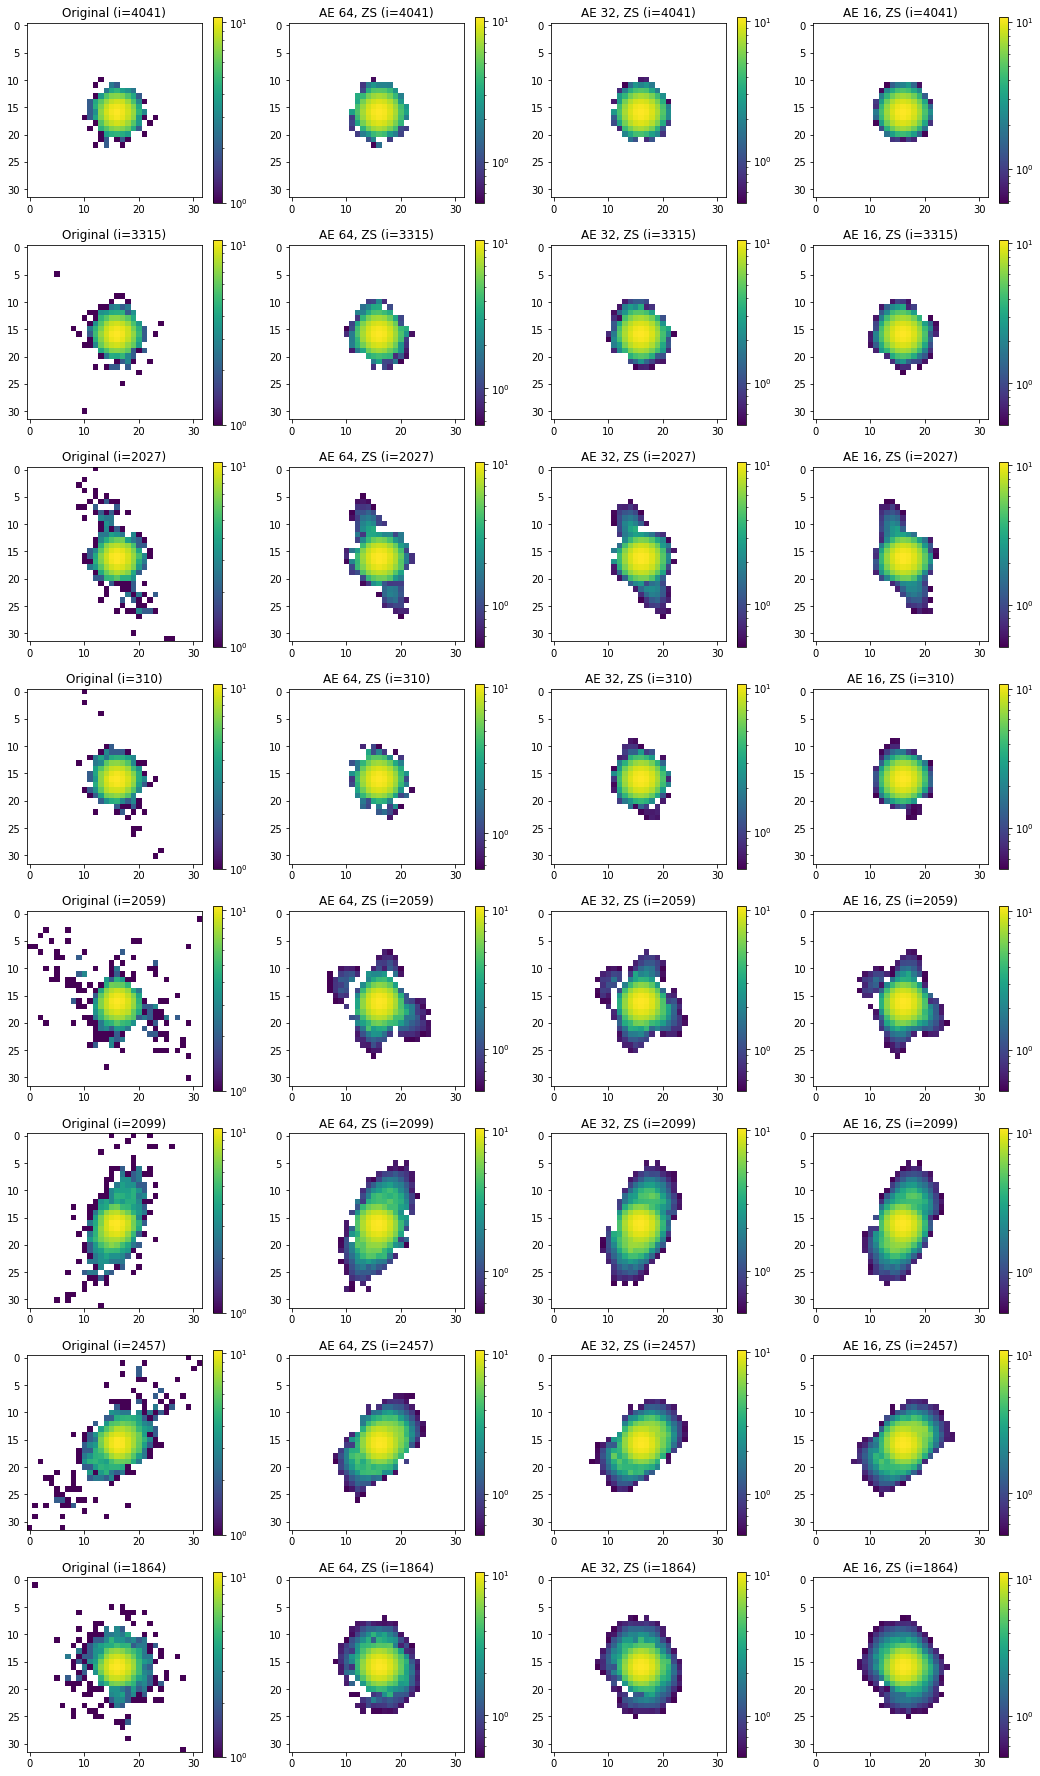

In [12]:
fig,ax = plt.subplots(len(N),4,figsize=(18,4*len(N)))

for i in range(len(N)):
    im = ax[i][0].imshow(dataFlatLog[N[i]].reshape(32,32),norm=LogNorm())
    fig.colorbar(im,ax=ax[i][0])
    ax[i][0].set_title(f'Original (i={N[i]})')
    
    im = ax[i][1].imshow(output64ZS[N[i]].reshape(32,32),norm=LogNorm())
    fig.colorbar(im,ax=ax[i][1])
    ax[i][1].set_title(f'AE 64, ZS (i={N[i]})')

    im = ax[i][2].imshow(output32ZS[N[i]].reshape(32,32),norm=LogNorm())
    fig.colorbar(im,ax=ax[i][2])
    ax[i][2].set_title(f'AE 32, ZS (i={N[i]})')

    im = ax[i][3].imshow(output16ZS[N[i]].reshape(32,32),norm=LogNorm())
    fig.colorbar(im,ax=ax[i][3])
    ax[i][3].set_title(f'AE 16, ZS (i={N[i]})')
    
    